# Sendy Logistics

The costs of logistics in Sub-Saharan Africa increase the costs of manufactured goods up to 320% whereas in Europe it is only 90% of the manufacturing cost. Economies are better when logistics are efficient and affordable.

Sendy is a logistics company situated in Nairobi, Kenya, established in 2014 to enable businesses of all types and sizes to transport goods more efficiently across East Africa.

<br>

***“We believe in them; we believe that logistics should be an enabler for them to achieve their goals, rather than a hindrance. We believe that everyone should be able to participate and thrive in the economy and that no small business should be left out because the cost of logistics is either too high or inaccessible.”***

<br>

The purpose of the notebook aims to help Sendy predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination. This will enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. 

In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

### Objective:

The objective of this notebook is to build a model to accurately predict the arrival time of goods sent through Sendys. This will help all businesses to improve their logistics and communicate an accurate time to their customers.



### Python Libraries

***This notebook was designed with the following libraries. Should you not have them already installed, simply uncomment the cell below and run it to pip install.***

In [135]:
# !pip install xgboost
# !pip install ipython
# !pip install plotly==4.8.1
# !pip install geopy
# !pip install cufflinks 
# !pip install plotnine
# !pip install -U ggplot

In [136]:
# Import python libraries

from statsmodels.api import OLS
from geopy.distance import distance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
import xgboost as xgb
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.neighbors import *
from sklearn.isotonic import *
from sklearn.gaussian_process import *
from sklearn import *
from sklearn.svm.classes import *
from sklearn.ensemble import*
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.api import add_constant
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
import cufflinks as cf
import plotly.express as px
from plotnine import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Packages used to display the Exploratory Data Analysis(EDA)

from pandas_profiling import ProfileReport
from IPython.display import IFrame
color = sns.color_palette()
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

%matplotlib inline

### Datasets

#####  **Variable definitions**

<br>

The Variable definitions dataframe lists the column names found in the Rider, Train, Test and Sample Submissions dataframes and gives a brief description of the data found within the column.

<br> 

*Aside note:* Column names listed in this datframe may not appear the Rider, Train, Test and Sample Submissions dataframes because during the process of modelling the data, the columns may not be useful and will be removed.

In [137]:
# Importing the VariableDefinitions.csv file from github as a Pandas DataFrame.
# Creating new column names for the Pandas DataFrame.

vardefinitions_df = pd.read_csv(
    "https://raw.githubusercontent.com/thembeks/Regression-Sendy-Logistics-Challenge-Team-14/Predict/VariableDefinitions.csv",
    names=['column_name', 'description'])

# Set the Pandas DataFrame style to display all the contents within the columns.

vardefinitions_df.style.set_properties(
    subset=['description'], **{'width': '600px'})

,column_name,description
0,Order No,Unique number identifying the order
1,User Id,Unique number identifying the customer on a platform
2,Vehicle Type,"For this competition limited to bikes, however in practice Sendy service extends to trucks and vans"
3,Platform Type,"Platform used to place the order, there are 4 types"
4,Personal or Business,Customer type
5,Placement - Day of Month,Placement - Day of Month i.e 1-31
6,Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
7,Placement - Time,Placement - Time - Time of day the order was placed
8,Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
9,Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)


##### **Rider DataFrame**

The Rider Dataframe lists all the riders that have delivered orders for Sendy and any information pertaining to that particular rider.

In [138]:
# Importing the Riders.csv file from github as a Pandas DataFrame.

rider_df = pd.read_csv(
    'https://raw.githubusercontent.com/thembeks/Regression-Sendy-Logistics-Challenge-Team-14/Predict/Riders.csv')

# Replacing all the blank spaces between words in the column names with an underscore.

rider_df.columns = [col.replace(' ', '_').lower()
                    for col in rider_df.columns]

# Displays the first 10 rows of the rider DataFrame to show the layout of the DataFrame.

rider_df.head(10)

,rider_id,no_of_orders,age,average_rating,no_of_ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156
5,Rider_Id_720,2608,1798,13.2,504
6,Rider_Id_95,3464,1304,13.4,950
7,Rider_Id_122,4831,2124,14.1,1469
8,Rider_Id_900,1936,1436,14.2,610
9,Rider_Id_196,550,2379,13.4,224


In [139]:
# A Pandas method that prints the information about a DataFrame.
# The information printed: the index dtype,column dtypes, non-null values and memory usage.

rider_df.info()

# Returns a tuple representing the dimensionality of the DataFrame.

rider_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
rider_id          960 non-null object
no_of_orders      960 non-null int64
age               960 non-null int64
average_rating    960 non-null float64
no_of_ratings     960 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 37.6+ KB


(960, 5)

##### **Training set DataFrame**

In [140]:
# Importing the Train.csv file from github as a Pandas DataFrame.

train_df = pd.read_csv(
    'https://raw.githubusercontent.com/thembeks/Regression-Sendy-Logistics-Challenge-Team-14/Predict/Train.csv')

# Replacing all the blank spaces between words in the column names with an underscore.

train_df.columns = [col.replace(' ', '_').lower()
                    for col in train_df.columns]

# Displays the first 10 rows of the train DataFrame to show the layout of the DataFrame.

train_df.head(10)

,order_no,user_id,vehicle_type,platform_type,personal_or_business,placement_-_day_of_month,placement_-_weekday_(mo_=_1),placement_-_time,confirmation_-_day_of_month,confirmation_-_weekday_(mo_=_1),...,arrival_at_destination_-_time,distance_(km),temperature,precipitation_in_millimeters,pickup_lat,pickup_long,destination_lat,destination_long,rider_id,time_from_pickup_to_arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214
5,Order_No_7408,User_Id_1342,Bike,3,Business,14,5,3:07:35 PM,14,5,...,4:23:41 PM,9,27.2,NaN,-1.302583,36.767081,-1.257309,36.806008,Rider_Id_124,3191
6,Order_No_22680,User_Id_2803,Bike,3,Business,9,5,9:33:45 AM,9,5,...,10:19:45 AM,5,20.3,NaN,-1.279395,36.825364,-1.276574,36.851365,Rider_Id_114,1380
7,Order_No_21578,User_Id_1075,Bike,3,Business,11,1,2:13:01 PM,11,1,...,2:33:26 PM,3,28.7,NaN,-1.252796,36.800313,-1.255189,36.782203,Rider_Id_913,646
8,Order_No_5234,User_Id_733,Bike,3,Business,30,2,11:10:44 AM,30,2,...,1:19:35 PM,9,NaN,NaN,-1.255189,36.782203,-1.300255,36.825657,Rider_Id_394,3398
9,Order_No_1768,User_Id_2112,Bike,3,Business,23,5,4:48:54 PM,23,5,...,6:31:57 PM,14,24.6,NaN,-1.225322,36.808550,-1.215601,36.891686,Rider_Id_660,3439


In [141]:
# A Pandas method that prints the information about a DataFrame.
# The information printed: the index dtype,column dtypes, non-null values and memory usage.

train_df.info()

# Returns a tuple representing the dimensionality of the DataFrame.
train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
order_no                                     21201 non-null object
user_id                                      21201 non-null object
vehicle_type                                 21201 non-null object
platform_type                                21201 non-null int64
personal_or_business                         21201 non-null object
placement_-_day_of_month                     21201 non-null int64
placement_-_weekday_(mo_=_1)                 21201 non-null int64
placement_-_time                             21201 non-null object
confirmation_-_day_of_month                  21201 non-null int64
confirmation_-_weekday_(mo_=_1)              21201 non-null int64
confirmation_-_time                          21201 non-null object
arrival_at_pickup_-_day_of_month             21201 non-null int64
arrival_at_pickup_-_weekday_(mo_=_1)         21201 non-null int64
arrival_at_pickup_-_time   

(21201, 29)

#####  **Testing set DataFrame**

In [142]:
# Importing the Test.csv file from github as a Pandas DataFrame.

test_df = pd.read_csv(
    'https://raw.githubusercontent.com/thembeks/Regression-Sendy-Logistics-Challenge-Team-14/Predict/Test.csv')

# Replacing all the blank spaces between words in the column names with an underscore.

test_df.columns = [col.replace(' ', '_').lower()
                   for col in test_df.columns]

# Displays the first 10 rows of the test DataFrame to show the layout of the DataFrame.

test_df.head(10)

,order_no,user_id,vehicle_type,platform_type,personal_or_business,placement_-_day_of_month,placement_-_weekday_(mo_=_1),placement_-_time,confirmation_-_day_of_month,confirmation_-_weekday_(mo_=_1),...,pickup_-_weekday_(mo_=_1),pickup_-_time,distance_(km),temperature,precipitation_in_millimeters,pickup_lat,pickup_long,destination_lat,destination_long,rider_id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858
5,Order_No_14573,User_Id_2338,Bike,1,Personal,13,1,6:29:29 PM,13,1,...,1,6:39:02 PM,16,19.3,NaN,-1.256606,36.795974,-1.223983,36.898452,Rider_Id_452
6,Order_No_6731,User_Id_488,Bike,2,Personal,17,3,9:53:29 AM,17,3,...,3,10:08:00 AM,18,20.9,NaN,-1.225272,36.875672,-1.304713,36.808955,Rider_Id_704
7,Order_No_18436,User_Id_3764,Bike,3,Business,28,4,8:51:13 AM,28,4,...,4,8:58:53 AM,8,22.7,NaN,-1.273539,36.833775,-1.297299,36.789446,Rider_Id_62
8,Order_No_2288,User_Id_2866,Bike,3,Business,28,4,8:58:21 AM,28,4,...,4,9:30:35 AM,8,19.4,NaN,-1.255189,36.782203,-1.285770,36.759172,Rider_Id_177
9,Order_No_9063,User_Id_1329,Bike,3,Business,4,5,4:28:28 PM,4,5,...,5,4:44:01 PM,15,21.7,NaN,-1.273056,36.811298,-1.330552,36.714289,Rider_Id_674


In [143]:
# A Pandas method that prints the information about a DataFrame.
# The information printed: the index dtype,column dtypes, non-null values and memory usage.

test_df.info()

# Returns a tuple representing the dimensionality of the DataFrame.

test_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
order_no                                7068 non-null object
user_id                                 7068 non-null object
vehicle_type                            7068 non-null object
platform_type                           7068 non-null int64
personal_or_business                    7068 non-null object
placement_-_day_of_month                7068 non-null int64
placement_-_weekday_(mo_=_1)            7068 non-null int64
placement_-_time                        7068 non-null object
confirmation_-_day_of_month             7068 non-null int64
confirmation_-_weekday_(mo_=_1)         7068 non-null int64
confirmation_-_time                     7068 non-null object
arrival_at_pickup_-_day_of_month        7068 non-null int64
arrival_at_pickup_-_weekday_(mo_=_1)    7068 non-null int64
arrival_at_pickup_-_time                7068 non-null object
pickup_-_day_of_month                   7068 n

(7068, 25)

#####  **Sample submission DataFrame**

This database is the format in which we will submit our predicted test values to Zindi.

In [144]:
# Importing the SampleSumbmission.csv file from github as a Pandas DataFrame.

samplesubmission_df = pd.read_csv(
    'https://raw.githubusercontent.com/thembeks/Regression-Sendy-Logistics-Challenge-Team-14/Predict/SampleSubmission.csv')

# Replacing all the blank spaces between words in the column names with an underscore.

samplesubmission_df.columns = [col.replace(' ', '_').lower()
                               for col in samplesubmission_df.columns]

# Displays the first 10 rows of the sample submission DataFrame to show the layout of the DataFrame.

samplesubmission_df.head(10)

,order_no,time_from_pickup_to_arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN
5,Order_No_14573,NaN
6,Order_No_6731,NaN
7,Order_No_18436,NaN
8,Order_No_2288,NaN
9,Order_No_9063,NaN


#####  **Merged DataFrame**

<br>

The merged DataFrame will consist of the Training/Test DataFrame merged with the Rider DataFrame. This DataFrame will be used for the data transformation and modelling.

###### train_df DataFrame

In [145]:
# Merge the train and rider DataFrame using Pandas .merge() function
# Training datasets

train_df = pd.merge(train_df, rider_df, on='rider_id')

# Reorder the columns so that the dependent variable is at the end.
# Dependent Variable = 'time_from_pickup_to_arrival'

train_df = train_df[['order_no', 'user_id', 'vehicle_type', 'platform_type', 'personal_or_business',
                     'placement_-_day_of_month', 'placement_-_weekday_(mo_=_1)', 'placement_-_time',
                     'confirmation_-_day_of_month', 'confirmation_-_weekday_(mo_=_1)',
                     'confirmation_-_time', 'arrival_at_pickup_-_day_of_month',
                     'arrival_at_pickup_-_weekday_(mo_=_1)', 'arrival_at_pickup_-_time',
                     'pickup_-_day_of_month', 'pickup_-_weekday_(mo_=_1)', 'pickup_-_time',
                     'arrival_at_destination_-_day_of_month', 'arrival_at_destination_-_weekday_(mo_=_1)',
                     'arrival_at_destination_-_time', 'distance_(km)', 'temperature',
                     'precipitation_in_millimeters', 'pickup_lat', 'pickup_long', 'destination_lat',
                     'destination_long', 'rider_id', 'no_of_orders', 'age', 'average_rating',
                     'no_of_ratings', 'time_from_pickup_to_arrival']]

# Renaming the columns to make working with the DataFrames easier.

train_df.columns = ['order_no', 'user_id', 'vehicle_type', 'platform_type', 'personal_or_business',
                    'placement(DOM)', 'placement(weekday)', 'placement(time)', 'confirmation(DOM)',
                    'confirmation(weekday)', 'confirmation(time)', 'arrival_at_pickup(DOM)',
                    'arrival_at_pickup(weekday)', 'arrival_at_pickup(time)', 'pickup(DOM)',
                    'pickup(weekday)', 'pickup(time)', 'arrival_at_destination(DOM)',
                    'arrival_at_destination(weekday)', 'arrival_at_destination(time)', 'distance(km)',
                    'temperature', 'precipitation(mm)', 'pickup_lat', 'pickup_long', 'destination_lat',
                    'destination_long', 'rider_id', 'no_of_orders', 'age', 'average_rating',
                    'no_of_ratings', 'time_from_pickup_to_arrival']

###### test_df  DataFrame 

In [146]:
# Merge the test and rider DataFrame using Pandas .merge() function
# Testing datasets

test_df = pd.merge(test_df, rider_df, on='rider_id')

# Renaming the columns to make working with the DataFrames easier.

test_df.columns = ['order_no', 'user_id', 'vehicle_type', 'platform_type', 'personal_or_business',
                   'placement(DOM)', 'placement(weekday)', 'placement(time)', 'confirmation(DOM)',
                   'confirmation(weekday)', 'confirmation(time)', 'arrival_at_pickup(DOM)',
                   'arrival_at_pickup(weekday)', 'arrival_at_pickup(time)', 'pickup(DOM)',
                   'pickup(weekday)', 'pickup(time)', 'distance(km)', 'temperature',
                   'precipitation(mm)', 'pickup_lat', 'pickup_long', 'destination_lat',
                   'destination_long', 'rider_id', 'no_of_orders', 'age', 'average_rating',
                   'no_of_ratings']

###### Concatenating the DataFrame

In [147]:
# Joing the train_df and test_df into one DataFrame so the preprocessing won't have to be repeated.
# The DataFrames will be split when the preprocessing is done.

merged_df = pd.concat([train_df, test_df], sort=False)

# Displays the first 10 rows of the test DataFrame to show the layout of the DataFrame.

merged_df.head(10)

,order_no,user_id,vehicle_type,platform_type,personal_or_business,placement(DOM),placement(weekday),placement(time),confirmation(DOM),confirmation(weekday),...,pickup_lat,pickup_long,destination_lat,destination_long,rider_id,no_of_orders,age,average_rating,no_of_ratings,time_from_pickup_to_arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,1637,1309,13.8,549,745.0
1,Order_No_27440,User_Id_2642,Bike,3,Personal,18,5,3:41:17 PM,18,5,...,-1.326774,36.787807,-1.356237,36.904295,Rider_Id_432,1637,1309,13.8,549,2886.0
2,Order_No_14170,User_Id_3339,Bike,3,Business,31,5,12:51:41 PM,31,5,...,-1.255189,36.782203,-1.273412,36.818206,Rider_Id_432,1637,1309,13.8,549,2615.0
3,Order_No_21727,User_Id_3523,Bike,3,Personal,2,2,7:12:10 AM,2,2,...,-1.290315,36.757377,-1.223520,36.802061,Rider_Id_432,1637,1309,13.8,549,2986.0
4,Order_No_8301,User_Id_87,Bike,2,Personal,22,2,10:40:58 AM,22,2,...,-1.273524,36.799220,-1.300431,36.752427,Rider_Id_432,1637,1309,13.8,549,1602.0
5,Order_No_10440,User_Id_2801,Bike,3,Business,29,3,12:14:43 PM,29,3,...,-1.267427,36.787083,-1.343640,36.892534,Rider_Id_432,1637,1309,13.8,549,2313.0
6,Order_No_25321,User_Id_1882,Bike,1,Business,2,2,9:08:42 AM,2,2,...,-1.226887,36.807395,-1.259102,36.800577,Rider_Id_432,1637,1309,13.8,549,1638.0
7,Order_No_2476,User_Id_2260,Bike,1,Personal,19,5,4:12:56 PM,19,5,...,-1.256280,36.807586,-1.298135,36.821382,Rider_Id_432,1637,1309,13.8,549,1897.0
8,Order_No_14704,User_Id_2186,Bike,1,Personal,28,1,3:03:10 PM,28,1,...,-1.279520,36.816829,-1.328128,36.871900,Rider_Id_432,1637,1309,13.8,549,1698.0
9,Order_No_118,User_Id_3688,Bike,3,Business,14,4,2:42:58 PM,14,4,...,-1.255189,36.782203,-1.261323,36.865718,Rider_Id_432,1637,1309,13.8,549,2693.0


**Alignment of datasets**

<br>

Aligning the dataset of train_df to the test_df dataset by dropping extra columns in train_df.

In [148]:
# Using the Pandas .drop() method.
# Remove the columns that are not in test_df by specifying the column names and corresponding axis.

merged_df = merged_df.drop(['arrival_at_destination(DOM)', 'arrival_at_destination(weekday)',
                            'arrival_at_destination(time)', 'order_no'], axis=1)

### Exploratory Data Analysis

Exploratory Data Analysis(EDA) is an approach for data analysis that uses many tools(mainly graphical to maximize insight into a data set, extract important variables, detect outliers and anomalies, amongst other details that is missed when looking at DataFrame.


This step is very important especially when we model the data in order to apply Machine Learning techniques.


**Aside note:** The models are interactive

##### **Summary Statistics**

In [149]:
# A function that performs summary statistics over a DataFrame using Pandas methods.

def train_eda(df):
    """
   
   A quick analysis of the train_df DataFrame to get a brief overview of the data.
    
    The train_eda function performs summary statistics over the the train_df DataFrame. 
        - It returns the summary statistics, total number of missing values and the percentage of 
          missing values as well as  the number of values in each column and the data type. 
        - Summary statistics summarise and provides information about the sample data. 
        - It tells you something about the values within your data set. 
                - This includes: the average of the data (numerical)  and whether your data is skewed.
        - Summary statistics fall into three main categories:
                1. Measures of central tendancy - Tells you where the data is centered at, or where 
                                                  a trend lies.
                                                - Mean (average of the dataset)
                                                - Median (middle most number of the dataset) 
                                                - Mode (most common value in the dataset)
                2. Measures of variability - Describes the amount of spread in a set of data.
                                           - Range(maximum value - minimum value)
                                           - Interquartile range(where the middle 50% of the data lies)
                                           - Quartiles (divide a rank-ordered data set into four
                                             equal parts)
                                           - Standard deviation (squared root of variance, average 
                                             squared deviation from the population mean)
                3. Graphs and charts
                
    Parameters: 
    df (pd): a Pandas DataFrame representing train_df. It contains all the data in which the summary 
        statistics would be performed.
    
    Returns: 
    pd: A DataFrame of the summary statistics on each of the columns within the train_df. 
            - if the summary statistics don't respond to any column, it will return a NaN value.
      
      An Example:
    	        null_sum      null_pct     dtypes	 count	    mean	      std	
        age	       0	      0.000000	   int64	 21201	 984.742842   646.652835	

    """
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['std'] = df.std()
    eda_df['25%'] = df.quantile(q=0.25)
    eda_df['median'] = df.median()
    eda_df['75%'] = df.quantile(q=0.75)
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()

    return pd.DataFrame(eda_df)

In [150]:
train_eda(train_df)

,null_sum,null_pct,dtypes,count,mean,std,25%,median,75%,min,max
age,0,0.000000,int64,21201,984.742842,646.652835,495.000000,872.000000,1236.000000,96,3764
arrival_at_destination(DOM),0,0.000000,int64,21201,15.653837,8.798886,8.000000,15.000000,23.000000,1,31
arrival_at_destination(time),0,0.000000,object,21201,NaN,NaN,NaN,NaN,NaN,10:00:00 AM,9:59:57 AM
arrival_at_destination(weekday),0,0.000000,int64,21201,3.240225,1.567228,2.000000,3.000000,5.000000,1,7
arrival_at_pickup(DOM),0,0.000000,int64,21201,15.653837,8.798886,8.000000,15.000000,23.000000,1,31
arrival_at_pickup(time),0,0.000000,object,21201,NaN,NaN,NaN,NaN,NaN,10:00:00 AM,9:59:56 AM
arrival_at_pickup(weekday),0,0.000000,int64,21201,3.240225,1.567228,2.000000,3.000000,5.000000,1,7
average_rating,0,0.000000,float64,21201,13.882520,0.916071,13.600000,14.000000,14.300000,0,15.2
confirmation(DOM),0,0.000000,int64,21201,15.653837,8.798886,8.000000,15.000000,23.000000,1,31
confirmation(time),0,0.000000,object,21201,NaN,NaN,NaN,NaN,NaN,10:00:00 AM,9:59:58 AM


> Observations

- There are 21 201 rows of data and 33 columns
    - The precipitation_in_millimeters and temperature column are missing values.
        - precipitation_in_millimeters: 97.4% missing values.
        - temperature: 20.6% missing values.	
- The data types within the train_df:
    - 16 int64   
    - 7 float64   
    - 10 object
        - There are a few columns that consist of string or text values that need to be explored and cleaned before modelling.
        - Just because a type is not numeric does not mean it will not be useful or important when modelling.
        - By inspecting the columns, many are categorical or ordinal features that can be converted to numeric values through data cleaning and that they relate to the time_from pick up to arrival that we are trying to predict.
- For the object data types, returns the summary statistics as a NaN value as it cannot compute any values for the columns as it is a string.
    - It will only return the minimum and maximum values in that column.
- The mean is observed to be higher than the median and there is a big difference between the 75th percentile and the maximum value which could indicate there maybe be outliers within the dataset.


##### **Unique values**

In [151]:
# Function that counts all the unique values in a DataFrame and returns it in a new DataFrame.
# New DataFrame sorts the data in ascending order.

def train_unique(df):
    """

    Counts all of the unique values within the train_df DataFrame, to give an overview of the most 
    common values within a column in the DataFrame.

    The train_unique funtion counts the number of unique values in the DataFrame using the Pandas 
    .nunique() method.
        - Count distinct observations over requested axis and returns a Series with the number of 
          distinct observations (can ignore NaN values).
    The train_unique funtion is split into two parts because there is a big difference between 
    unique values which will become distorted when plotting on a graph. 

    The funtion takes the values returned from .nunique() and puts it into an empty list which is then
    converted into a Pandas DataFrame. 
        - The DataFrame is sorted in anscending order and the index is reset, to make it easier to 
          plot.
        -  In the funtions only selected columns are chosen based on the above summary statistics.
                - Function 1: vehicle_type, platform_type, personal_or_business, distance(km), 
                              temperature, precipitation(mm), average_rating
                - FUnction 2: no_of_ratings, age, no_of_orders, rider_id, user_id, order_no
    Parameters: 
    df (pd): a Pandas DataFrame representing the train_df. 

    Returns:
    pd: a DataFrame of the count of the unique values which will be used to plot a graph.

    """

    unique_df = {}

    unique_df['no_of_unique_values'] = train_df[['vehicle_type', 'platform_type',
                                                 'personal_or_business', 'distance(km)',
                                                 'temperature', 'precipitation(mm)', 'average_rating']
                                                ].nunique()

    unique_df = pd.DataFrame(unique_df).sort_values(
        by=['no_of_unique_values']).rename_axis('column_name').reset_index()

    return unique_df


def train_unique1(df):
    unique_df1 = {}

    unique_df1['no_of_unique_values'] = train_df[['no_of_ratings', 'age', 'no_of_orders', 'rider_id',
                                                  'user_id', 'order_no']
                                                 ].nunique()

    unique_df1 = pd.DataFrame(unique_df1).sort_values(
        by=['no_of_unique_values']).rename_axis('column_name').reset_index()

    return unique_df1

# Create an interactive visual to display the unique values of the above DataFrame
# Spilt into two visuals because the differences between unique values is large.


data = px.data.gapminder()
data1 = train_unique(train_df)
fig = px.bar(data1, x='no_of_unique_values',
             y='column_name', color='no_of_unique_values',
             labels={'no_of_unique_values': 'Unique values',
                     'column_name': 'Column Name'},
             height=400)
fig.show()

data2 = px.data.gapminder()
data3 = train_unique1(train_df)
fig = px.bar(data3, x='no_of_unique_values',
             y='column_name', color='no_of_unique_values',
             labels={'no_of_unique_values': 'Unique values',
                     'column_name': 'Column Name'},
             height=400)
fig.show()

- There is only one vehicle type used to in the dataset to make deliveries which is a bike.
- In the dataset, there is 21 201 order numbers which means there are no repeated values.
    - It is like the ID column for the dataset.
- There are currently 3 186 customers that use Sendy's services which means that customers have repeatly used Sendy's services. 
- 924 riders are currently making deliveries for Sendy, which indicates that Sendy repeatedly makes use of the same riders to make deliveries.

In [152]:
# Create an interactive visual to display the unique values of distances travelled.
# Bargraph plotted using .iplot() displaying the most common distance travelled for order deliveries

train_df['distance(km)'].value_counts().iplot(kind='bar', 
                                              bins=30, 
                                              theme='white', 
                                              color= 'purple',
                                              title='Total distance travelled per order', 
                                              xTitle='Distance(km)', 
                                              yTitle='Count')

# Create an interactive visual to display the unique values of distances travelled.
# Boxplot using iplot displaying the distribution of the data via the relatioships between percentiles.

train_df['distance(km)'].iplot(kind='box', color= 'purple')

- The minimum distance travelled in 1km and the maximum distance travelled is 49km.
- The mean distance travelled is 9.5km which is above the median distance travelled of 8km.
- From the above graphs, we can see that there are a lot of outliers in the database.
    - It may effect on the model since distance has shown to have the highest correlation with the dependent variable.  
- 75% of the orders in our dataset are delivered within a distance of 13km which means that our data is heavily skewed to the right. 

In [153]:
# Create an interactive visual to display the count of each unique value of distances travelled.
# Bargraph plotted using .iplot() displaying the most common platform types used to place orders.

train_df['platform_type'].value_counts().iplot(kind='bar',
                                               bins=10,
                                               theme='white',
                                               color='purple',
                                               title='Most common platform types used to place orders',
                                               xTitle='Platform Types',
                                               yTitle='Count')

- There are 4 types of platform types, the most common being platform 3 and the least platform 4.
- Platform 3 is the median and modal values.
- From the above graph the, we can see the dataset is not evenly distributed.

In [154]:
# Create an interactive visual to display the unique values of distances travelled.
# Bargraph plotted using .iplot() displaying who makes use of Sendy's services the most.

train_df['personal_or_business'].value_counts().iplot(kind='bar',
                                                      bins=10,
                                                      theme='white',
                                                      color='purple',
                                                      title='Who uses Sendys services the most?',
                                                      xTitle='Personal or Business',
                                                      yTitle='Count')

- More that 50% of the Sendy's orders come from Business'.
    - Business is the median and modal value of the dataset.

In [155]:
# Create an interactive visual to display the unique values of distances travelled.
# Bargraph plotted using .iplot() displaying who makes use of Sendy's services the most.

train_df['user_id'].value_counts().iplot(kind='bar',
                                         bins=50,
                                         theme='white',
                                         color='purple',
                                         title='Who uses Sendys services the most?',
                                         xTitle='User ID',
                                         yTitle='Count')

- From the above graph, we can see that user_id_393 placed the most orders at 645 which is also the modal value.
- Many of sendy's customers have made atleast 2 orders with Sendy. 

In [156]:
# Create an interactive visual to display the unique values of distances travelled.
# Bargraph plotted using .iplot() displaying the count for each driver making deliveries.

train_df['rider_id'].value_counts().iplot(kind='bar',
                                          bins=50,
                                          theme='white',
                                          color='purple',
                                          title='How many times each Rider has made deliveries for Sendy?',
                                          xTitle='Rider ID',
                                          yTitle='Count')

- rider_id_726 has made the most deliveries for Sendy at 247 which is also the modal value of the datset. 
- Many of the delivery personnel have made atleast 1 delivery for Sendy. 

##### **Busiest days for orders**

In [157]:
# Function that counts the number of unique values per category and returns it in a new DataFrame.
# New DataFrame sorts the data in days starting from the first of the month.

def train_countm(df):
    """
     A quick analysis of the train_df DataFrame to get a breakdown of the busiest times for Sendys.

    The train_countm function takes all the values in the placement(DOM), confirmation(DOM), 
    arrival at pickup(DOM), pickup(DOM), arrival at destination(DOM) and groups the values together.
        - An empty dictionary is created, countm_df.
        - Using the Pandas .value_counts() method, it counts the number of like values within the 
          columns and returns the number into the empty dictionary, countm_df.  
        - The count,_df dictionary is then converted into a DataFrame using the pd.DataFrame method.
        - The DataFrames axis is renamed to reflect the days of the month, to make it easier 
          to interpret.

    Parameters: 
    df (pd): a Pandas DataFrame representing train_df. It contains all the data in which the 
             .value_counts() method would be performed on the specified columns.

    Returns: 
    pd: A DataFrame of the total count of the each unique value within the specified columns. 


      An Example:
           placement(DOM)   confirmation(DOM)	arrival_at_pickup(DOM)   pickup(DOM)	
      day					
       1	     482	          482	               482	                 482	

    """

    countm_df = {}

    countm_df['placement(DOM)'] = train_df['placement(DOM)'].value_counts()
    countm_df['confirmation(DOM)'] = train_df['confirmation(DOM)'].value_counts()
    countm_df['arrival_at_pickup(DOM)'] = train_df['arrival_at_pickup(DOM)'].value_counts()
    countm_df['pickup(DOM)'] = train_df['pickup(DOM)'].value_counts()
    countm_df['arrival_at_destination_-(DOM)'] = train_df['arrival_at_destination(DOM)'].value_counts()

    countm_df = pd.DataFrame(countm_df).rename_axis('day')

    return countm_df

In [158]:
train_countm(train_df)

,placement(DOM),confirmation(DOM),arrival_at_pickup(DOM),pickup(DOM),arrival_at_destination_-(DOM)
day,,,,,
1,482,482,482,482,482
2,602,602,602,602,602
3,718,718,718,718,718
4,769,769,769,769,769
5,747,747,747,747,747
6,794,794,794,794,794
7,822,822,822,822,822
8,848,848,848,848,848
9,667,667,667,667,667


- From the above table, we can see that that from the placement day of the month to the arrival destination day that the are all the same value.
    - This could indicate that there is a direct correlation between all of these values. 
- From this information we can see that orders and deliveris occur everyday and that there is no break from when the company is operational

In [159]:
# A function that groups the days of the month columns in the train_df by weeks.
# Returns a new DataFrame of the counted grouped values within the columns.

def group_by_week(df, column_name):
    """
    A quick analysis of the train_df DataFrame to get a breakdown of the busiest times for Sendys in
    terms of weeks.

    The group_by_week function takes all the values in the placement(DOM), confirmation(DOM), 
    arrival at pickup(DOM), pickup(DOM), arrival at destination(DOM) and groups the values together
    so that it is represented in weeks of a month rather than days of the month. 
        - This is only done to the placement(DOM), as from the above analysis it shows all the values 
          are the same. 
        - An empty list is created, values.
        - An if statement is then looped over the length of the train_df Dataframe.
        - The values are then sorted by a specific criteria and placed into a new row in the DataFrame.
        - The DataFrame is then plotted into a bargraph to make it easier to interpret which weeks are
          the busiest for Sendy.

    Parameters: 
    df (pd): a Pandas DataFrame representing train_df which is then sorted into the five categories of
             weeks.

    Returns: 
    pd: A DataFrame of the total count of the each category within the specified columns. 

    bargraph: The DataFrame is then plotted into an interactive bargraph to make interpretation and
              analysis easier.    

    """
    values = []
    for row in range(len(df)):
        if df[column_name][row] <= 7:
            values.append(1)
        if df[column_name][row] <= 14:
            values.append(2)
        if df[column_name][row] <= 21:
            values.append(3)
        if df[column_name][row] <= 28:
            values.append(4)
        else:
            values.append(5)
    values = pd.DataFrame(values)

    return pd.DataFrame(values.iloc[:, 0].value_counts().sort_index())

# Create an interactive visual to display the total count of orders placed during a month in weeks.
# Bargraph plotted using .iplot() displaying the count for each week for orders.


group_by_week(train_df, 'placement(DOM)').iplot(kind='bar',
                                                bins=50,
                                                theme='white',
                                                color='purple',
                                                title='The busiest weeks in a month for orders',
                                                xTitle='Weeks',
                                                yTitle='Count')

- The busiest week for deliveries is the fourth week.
    - This makes sense because it's month end and many people get paid during that week and would like to have goods delivered to their customers or relatives. 
    - Week four is the modal value as seen from the graph.
- The least busiest week is week 1, not week 5 as it is month end and can be linked to week 4.

In [160]:
# Create an interactive visual to display the total count of orders placed during a week in days.
# Bargraph plotted using .iplot() displaying the count for each day for orders.

train_df['placement(weekday)'].value_counts().iplot(kind='bar',
                                                    bins=50,
                                                    theme='white',
                                                    color='purple',
                                                    title='The busiest day of the week for order placement',                                                    xTitle='Days Of The Week',
                                                    yTitle='Count')

- From the above graph, Thursday is the busiest day of the week and in second comes friday.
    - I assume this is due to the many people would like their packages delivered before the weekend.
    - Thursday is also the modal value for the data as it has the most orders placed.
- The least busiest time for Sendys is Sunday as seen from the graph as only 186 orders have taken place.

##### **The behaviour of delivery time (Dependent Variable)**

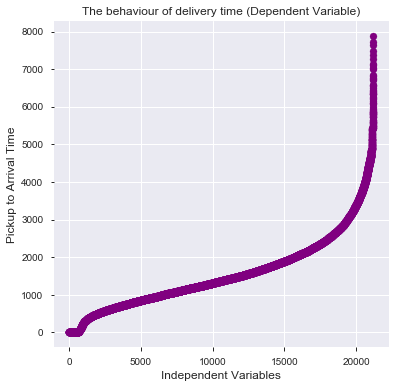

In [161]:
# Scatterplot plotted using matplotlib.pyplot library
# Represents the relationship between the independent variable(X) and dependent variable(Y).

plt.figure(figsize=(6, 6))
plt.scatter(range(train_df.shape[0]), np.sort(
    train_df.time_from_pickup_to_arrival.values),
    color='purple')
plt.xlabel('Independent Variables',
           fontsize=12)
plt.ylabel('Pickup to Arrival Time',
           fontsize=12)
plt.title('The behaviour of delivery time (Dependent Variable)')
plt.show()

##### **Correlations**

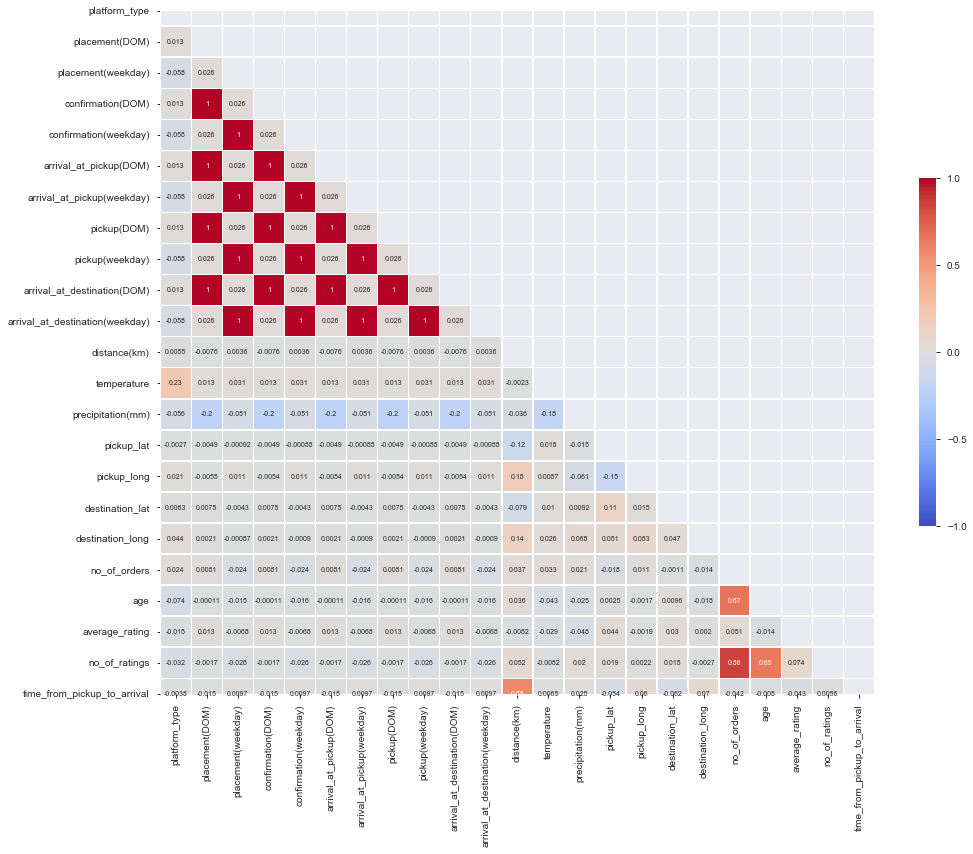

In [162]:
# Pearson heatmap representing the relationship between the variables of the train_df DataFrame.

testing = np.zeros_like(train_df.corr(method='pearson'), dtype=np.bool)
testing[np.triu_indices_from(testing)] = True
f, ax = plt.subplots(figsize=(16, 16))

heatmap = sns.heatmap(train_df.corr(method='pearson'),
                      mask=testing,
                      square=True,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws={'shrink': .4,
                                'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': 7})

# Add the column names as labels
ax.set_yticklabels(train_df.corr(method='pearson').columns, rotation=0)
ax.set_xticklabels(train_df.corr(method='pearson').columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

- There is a direct relationship between the day of months columns as the p-score is 1.
- There is a high correlation between the riders no. of ratings and the no. of orders the riders delivers. 
- There are alot of week relationships between the other columns as there are low correlations between the columns. 
- Precipitation(mm) has a weak negative relationship between the columns.
- Most of the columns ahve week relationships between themselves as they are very close to zero. 

##### **Geoplots**

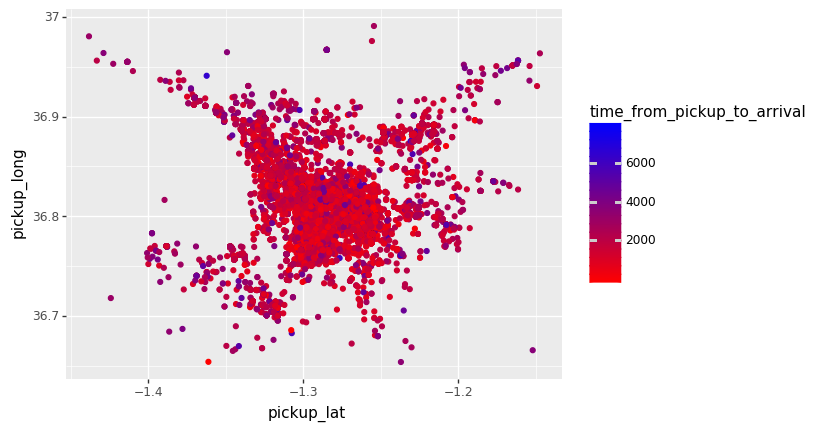

<ggplot: (-9223371954567456568)>

In [163]:
# Geoplot showing the relationship between the pickup latitude and longitude coordintates and time.

ggplot(aes(x='pickup_lat', 
           y='pickup_long', 
           color='time_from_pickup_to_arrival'), 
           data=train_df) + \
           geom_point() + \
           scale_color_gradient(low='red', high='blue')

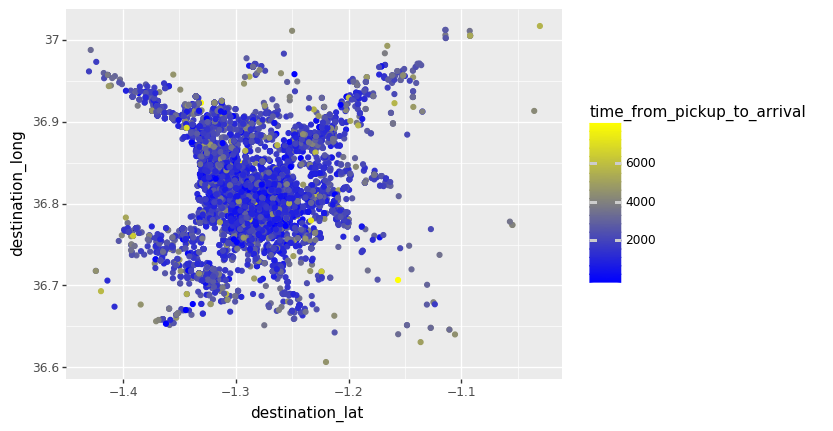

<ggplot: (-9223371954567455628)>

In [164]:
# Geoplot showing the relationship between the destination latitude, longitude coordintates and time.

ggplot(aes(x='destination_lat', 
           y='destination_long', 
           color= 'time_from_pickup_to_arrival'), 
           data=train_df) + \
           geom_point() + \
           scale_color_gradient(low = 'blue', high = 'yellow')


- The distance of drop-offs are wider spread than pick up points,
    - Many destination arrival time will be influenced by wider distances. 
- I also notice that lengthy times for deliveries occur in both the central and outlier destinations. 
    - Traffic congestion and distance are all influential in the pick to arrival time duration

##### **Quick Analysis**

In [165]:
# Quick profile analysis over the train_df DataFrame.
# Pandas Profile Report using pandas_profiling library.

profile_train_df = ProfileReport(train_df, check_correlation=True)
profile_train_df.to_file(outputfile='output.html')
HtmlFile = open('output.html', 'r', encoding='utf-8')
source_code = HtmlFile.read()

IFrame(src='./output.html', width=900, height=800)

# Part 1: Baseline Model

For the purpose of Part 1, minimal feature engineering will be done to the dataset. It will be done to the extent that the data will be able to fit into a model as is.


### Transformation and Processing of data

> **Missing data**

In [166]:
# Using the Pandas .replace() method, replace all NaN values with 0.

merged_df = merged_df.replace(np.nan, 0)

> **Converting time into seconds**

In [167]:
# Converting time strings to seconds using the Pandas .to_timedelta() method.
# Using the .dt accessor object for datetimelike properties of the Series values to convert to seconds.

merged_df['placement(time)'] = pd.to_timedelta(
    merged_df['placement(time)']).dt.total_seconds()

merged_df['confirmation(time)'] = pd.to_timedelta(
    merged_df['confirmation(time)']).dt.total_seconds()

merged_df['arrival_at_pickup(time)'] = pd.to_timedelta(
    merged_df['arrival_at_pickup(time)']).dt.total_seconds()

merged_df['pickup(time)'] = pd.to_timedelta(
    merged_df['pickup(time)']).dt.total_seconds()

> **Dropping columns**

In [168]:
# Using the Pandas .drop() method.
# Remove columns that are not useful by specifying the column names and corresponding axis.

merged_df = merged_df.drop(['user_id', 'vehicle_type', 'rider_id'], axis=1)

> **Encoding categorical data**

In [169]:
# Encoding categorical data using Pandas .get_dummies() method.

merged_df = pd.get_dummies(merged_df, columns=[
                            'platform_type', 'personal_or_business'], 
                             drop_first=True)

> **How the DataFrame looks after the data transformation process**

In [170]:
# Displays the first 10 rows of the merged DataFrame to show the layout of the DataFrame.

merged_df.head(10)

,placement(DOM),placement(weekday),placement(time),confirmation(DOM),confirmation(weekday),confirmation(time),arrival_at_pickup(DOM),arrival_at_pickup(weekday),arrival_at_pickup(time),pickup(DOM),...,destination_long,no_of_orders,age,average_rating,no_of_ratings,time_from_pickup_to_arrival,platform_type_2,platform_type_3,platform_type_4,personal_or_business_Personal
0,9,5,34546.0,9,5,34810.0,9,5,36287.0,9,...,36.829741,1637,1309,13.8,549,745.0,0,1,0,0
1,18,5,13277.0,18,5,13290.0,18,5,14836.0,18,...,36.904295,1637,1309,13.8,549,2886.0,0,1,0,1
2,31,5,46301.0,31,5,4369.0,31,5,4802.0,31,...,36.818206,1637,1309,13.8,549,2615.0,0,1,0,0
3,2,2,25930.0,2,2,25949.0,2,2,27324.0,2,...,36.802061,1637,1309,13.8,549,2986.0,0,1,0,1
4,22,2,38458.0,22,2,38544.0,22,2,39360.0,22,...,36.752427,1637,1309,13.8,549,1602.0,1,0,0,1
5,29,3,44083.0,29,3,44151.0,29,3,44514.0,29,...,36.892534,1637,1309,13.8,549,2313.0,0,1,0,0
6,2,2,32922.0,2,2,32937.0,2,2,33265.0,2,...,36.800577,1637,1309,13.8,549,1638.0,0,0,0,0
7,19,5,15176.0,19,5,15379.0,19,5,16234.0,19,...,36.821382,1637,1309,13.8,549,1897.0,0,0,0,1
8,28,1,10990.0,28,1,11078.0,28,1,12045.0,28,...,36.871900,1637,1309,13.8,549,1698.0,0,0,0,1
9,14,4,9778.0,14,4,9877.0,14,4,11100.0,14,...,36.865718,1637,1309,13.8,549,2693.0,0,1,0,0


In [171]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28269 entries, 0 to 7067
Data columns (total 28 columns):
placement(DOM)                   28269 non-null int64
placement(weekday)               28269 non-null int64
placement(time)                  28269 non-null float64
confirmation(DOM)                28269 non-null int64
confirmation(weekday)            28269 non-null int64
confirmation(time)               28269 non-null float64
arrival_at_pickup(DOM)           28269 non-null int64
arrival_at_pickup(weekday)       28269 non-null int64
arrival_at_pickup(time)          28269 non-null float64
pickup(DOM)                      28269 non-null int64
pickup(weekday)                  28269 non-null int64
pickup(time)                     28269 non-null float64
distance(km)                     28269 non-null int64
temperature                      28269 non-null float64
precipitation(mm)                28269 non-null float64
pickup_lat                       28269 non-null float64
pickup_long   

###### **Splitting the data**

> Separating the Training dataset into the Independent variable and Dependent variable.

In [172]:
# Splitting the baseline_train DataFrame into the X and Y variable using the Pandas .iloc[] method.

Y = merged_df[:len(train_df)][['time_from_pickup_to_arrival']]
X = merged_df[:len(train_df)].drop('time_from_pickup_to_arrival', axis=1)

# for predictions
Xtrain = merged_df[:len(train_df)].drop('time_from_pickup_to_arrival', axis=1)
Xpred = merged_df[len(train_df):].drop('time_from_pickup_to_arrival', axis=1)

> **Splitting the dataset into the training and test set**

In [173]:
# Using sklearn.model_selection, train_test_split() method to split the baseline_X and baseline_Y.
# Test size will be 0.2 (20% of the data will the test case).

baseline_Xtrain, baseline_Xtest, baseline_Ytrain, baseline_Ytest = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=21)

### Multiple models 

In [174]:
# A list of variable names assigned to each of the regressors used in the modelling.

names = ['Linear', 'Lasso', 'Ridge', 'Elastic Net',  'Random Forest Regressor', 'XGboost',
         'DecisonTree']

In [175]:
# Assigning each of the regression models to an object.
# Creating a model to test all the regression models at once.

regressors = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    ElasticNet(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
    DecisionTreeRegressor()
]

In [176]:
# Fitting the regression models to the training datset.
# Predicting the results of the testing datset
# Calculation the accuracy of each model and returning the results into a DataFrame.

results = []
models = {}
for name, reg in zip(names, regressors):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o reg.fit(baseline_Xtrain, baseline_Ytrain)
    
    print ('... predicting')
    y_pred = reg.predict(baseline_Xtest)   
        
    print ('... scoring')
    RMSE  = np.sqrt(mean_squared_error(baseline_Ytest, y_pred))
    MSE = mean_squared_error(baseline_Ytest, y_pred)
    RSS = mean_squared_error(baseline_Ytest, y_pred)*len(train_df)
    R2 = r2_score(baseline_Ytest, y_pred)
    
        
    # save the results to dictionaries
    models[name] = reg    
    
    results.append([name, RMSE, MSE, RSS, R2, run_time.best])
    
results = pd.DataFrame(results, columns=['Regressor', 'RMSE', 'MSE', 'RSS', 'R2', 'Train Time'])
results.set_index('Regressor', inplace= True)

Fitting Linear model...
... predicting
... scoring
Fitting Lasso model...
... predicting
... scoring
Fitting Ridge model...
... predicting
... scoring
Fitting Elastic Net model...
... predicting
... scoring
Fitting Random Forest Regressor model...


C:\Users\Suzzy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\Suzzy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Suzzy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Suzzy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\Suzzy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expect

... predicting
... scoring
Fitting XGboost model...
[14:05:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:05:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
... predicting
... s

In [177]:
# Sorting the results of the RMSE in the DataFrame in descending order.

results.sort_values('RMSE', ascending=False)

,RMSE,MSE,RSS,R2,Train Time
Regressor,,,,,
DecisonTree,1113.829832,1.240617e+06,2.630232e+10,-0.291837,0.296909
Random Forest Regressor,809.778198,6.557407e+05,1.390236e+10,0.317186,1.871108
Elastic Net,790.987559,6.256613e+05,1.326465e+10,0.348507,0.170093
Lasso,790.099700,6.242575e+05,1.323488e+10,0.349969,0.020301
Linear,788.899202,6.223620e+05,1.319470e+10,0.351943,0.007393
Ridge,788.720233,6.220796e+05,1.318871e+10,0.352237,0.005049
XGboost,756.024888,5.715736e+05,1.211793e+10,0.404828,0.974332


In [178]:
# Create an interactive visual to display the run time and the RMSE of each regressor.
# Bargraph plotted using .iplot() displaying the run time and the RMSE.

results.sort_values('RMSE', ascending=False, inplace=True)
results.iplot(y=['RMSE'], kind='bar', color= 'orchid', ax=ax[0]) 
results.iplot(y='Train Time', kind='bar', color= 'purple', ax=ax[1])

TypeError: 'AxesSubplot' object is not subscriptable

- From the above, we can see that the Decision tree regressor has the highest RMSE and the XGBoost has the least but when comparing the run time of both, the decision tree took the less time.
    - XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. 
    - It is similar to decision trees as it follows the same concept except it selects the most benficial features to build and fit a model. 
    - This is the reason it performed better than the other models. 

# Part 2: Model Enhancements

For the purpose of Part 2, the minimal feature engineering that was done in Part 1 will be used where we select certain features that has the biggest influence on the models.

### Feature Importance

##### XGB Analysis

In [ ]:
# Using plot importance from xgboost, it lists the hierachy of the most important features.
# Hierachy correspands only to the XGBoost regressor

baseline_xgbregression= xgb.XGBRegressor()

plt.rcParams["figure.figsize"] = (15, 15)
plot_importance(baseline_xgbregression.fit(baseline_Xtrain, baseline_Ytrain), 
                color= 'purple')
plt.show()

From the above graph, we can see the feature importance for XGB regression. 
    - The important features are: distance(km), destination_lat, destination_long, age, 
                           pickup_lat, pickup_long,average_rating and the no_of_orders. 
Therefore, we will aplly the above regression model to only these selected features and see if it will make any difference to the RMSE score.

###### **Splitting the dataset**

In [ ]:
# Splitting the baseline_train DataFrame into the X and Y variable using the Pandas .iloc[] method.

xgb_Y = merged_df[:len(train_df)][['time_from_pickup_to_arrival']]
xgb_X = merged_df[:len(train_df)].drop(['placement(DOM)', 'placement(weekday)', 'placement(time)',
                                        'confirmation(DOM)', 'confirmation(weekday)', 'confirmation(time)',
                                        'arrival_at_pickup(DOM)', 'arrival_at_pickup(weekday)',
                                        'arrival_at_pickup(time)', 'pickup(DOM)', 'pickup(weekday)',
                                        'pickup(time)', 'temperature', 'precipitation(mm)',
                                        'no_of_ratings', 'time_from_pickup_to_arrival', 'platform_type_2',
                                        'platform_type_3', 'platform_type_4',
                                        'personal_or_business_Personal'], axis=1)

# for predictions
xgb_Xtrain = merged_df[:len(train_df)].drop(['placement(DOM)', 'placement(weekday)', 'placement(time)',
                                             'confirmation(DOM)', 'confirmation(weekday)', 'confirmation(time)',
                                             'arrival_at_pickup(DOM)', 'arrival_at_pickup(weekday)',
                                             'arrival_at_pickup(time)', 'pickup(DOM)', 'pickup(weekday)',
                                             'pickup(time)', 'temperature', 'precipitation(mm)',
                                             'no_of_ratings', 'time_from_pickup_to_arrival', 'platform_type_2',
                                             'platform_type_3', 'platform_type_4',
                                             'personal_or_business_Personal'], axis=1)
xgb_Xpred = merged_df[len(train_df):].drop(['placement(DOM)', 'placement(weekday)', 'placement(time)',
                                            'confirmation(DOM)', 'confirmation(weekday)', 'confirmation(time)',
                                            'arrival_at_pickup(DOM)', 'arrival_at_pickup(weekday)',
                                            'arrival_at_pickup(time)', 'pickup(DOM)', 'pickup(weekday)',
                                            'pickup(time)', 'temperature', 'precipitation(mm)',
                                            'no_of_ratings', 'time_from_pickup_to_arrival', 'platform_type_2',
                                            'platform_type_3', 'platform_type_4',
                                            'personal_or_business_Personal'], axis=1)

In [ ]:
# Using sklearn.model_selection, train_test_split() method to split the baseline_X and baseline_Y.
# Test size will be 0.2 (20% of the data will the test case).

baseline_Xtrain, baseline_Xtest, baseline_Ytrain, baseline_Ytest = train_test_split(
    xgb_X, xgb_Y,
    test_size=0.2,
    random_state=21)

###### **Multiple models**

In [ ]:
# Fitting the regression models to the training datset.
# Predicting the results of the testing datset
# Calculation the accuracy of each model and returning the results into a DataFrame.

results = []
models = {}
for name, reg in zip(names, regressors):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o reg.fit(baseline_Xtrain, baseline_Ytrain)
    
    print ('... predicting')
    y_pred = reg.predict(baseline_Xtest)   
        
    print ('... scoring')
    RMSE  = np.sqrt(mean_squared_error(baseline_Ytest, y_pred))
    MSE = mean_squared_error(baseline_Ytest, y_pred)
    RSS = mean_squared_error(baseline_Ytest, y_pred)*len(train_df)
    R2 = r2_score(baseline_Ytest, y_pred)
    
        
    # save the results to dictionaries
    models[name] = reg    
    
    results.append([name, RMSE, MSE, RSS, R2, run_time.best])
    
results = pd.DataFrame(results, columns=['Regressor', 'RMSE', 'MSE', 'RSS', 'R2', 'Train Time'])
results.set_index('Regressor', inplace= True)

In [ ]:
# Sorting the results of the RMSE in the DataFrame in descending order.

results.sort_values('RMSE', ascending=False)

In [ ]:
# Create an interactive visual to display the run time and the RMSE of each regressor.
# Bargraph plotted using .iplot() displaying the run time and the RMSE score.

results.sort_values('RMSE', ascending=False, inplace=True)
results.iplot(y=['RMSE'], kind='bar', color= 'orchid', ax=ax[0]) 
results.iplot(y='Train Time', kind='bar', color= 'purple', ax=ax[1])

- If we do a comparison between Part 1 and Part 2 RMSE scores:
    - By removing the none important features from the model, it made no difference to the XGBoost RMSE score, this further proves that XGBoost automatically selects the best features to build and fit a model.
    - The removal of features made a big difference for the Decision Tree regression as the RMSE score dropped quite significantly. 
    - As for the other models, their RMSE score also dropped slightly. 
    - The Decision Tree regression still has the highest RMSE score out of all of the models. 

##### P-score Analysis

In [ ]:
# Create a list of the feature names - which will be used in our final dataframe
feature_names = ['placement(DOM)', 'placement(weekday)', 'placement(time)',
       'confirmation(DOM)', 'confirmation(weekday)', 'confirmation(time)',
       'arrival_at_pickup(DOM)', 'arrival_at_pickup(weekday)',
       'arrival_at_pickup(time)', 'pickup(DOM)', 'pickup(weekday)',
       'pickup(time)', 'distance(km)', 'temperature', 'precipitation(mm)',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'no_of_orders', 'age', 'average_rating', 'no_of_ratings',
       'platform_type_2', 'platform_type_3', 'platform_type_4',
       'personal_or_business_Personal'
       ]

# Create a empty list g, which will be appended with information of each feature
g = []

for column in X:
    regression = OLS(Y, add_constant(X[[column]])).fit()
    regression_params = regression.params[1]
    regression_tvalues = regression.tvalues[1]
    regression_pvalues = regression.pvalues[1]
    
    g.append([regression_params, regression_tvalues, regression_pvalues])

# Create dataframe with coefficient, t statistc and p-value per feature and sort by p-value
g = pd.DataFrame(data=np.array(g).reshape([27,3]), index=feature_names, columns=['Coefficient', 't statistic', 'p value'])
g.sort_values(by='p value')

For the p-score analysis we will use a 95% confidence interval to test the feature importance.
    - The important features are: distance(km), destination_long, destination_lat, 
                     pickup_long, pickup_lat, average_rating, no_of_orders, temperature,
                     placement(DOM), pickup(DOM), confirmation(DOM) and 
                     arrival_at_pickup(DOM)

Therefore, we will aplly the above regression model to only these selected features and see if it will make any difference to the RMSE score.

###### **Splitting the dataset**

In [ ]:
# Splitting the baseline_train DataFrame into the X and Y variable using the Pandas .iloc[] method.

pscore_Y = merged_df[:len(train_df)][['time_from_pickup_to_arrival']]
pscore_X = merged_df[:len(train_df)].drop(['placement(weekday)', 'placement(time)',
                                           'confirmation(weekday)', 'confirmation(time)',
                                           'arrival_at_pickup(DOM)', 'arrival_at_pickup(weekday)',
                                           'pickup(weekday)', 'pickup(time)', 'precipitation(mm)', 'age',
                                           'no_of_ratings', 'time_from_pickup_to_arrival',
                                           'platform_type_2', 'platform_type_3', 'platform_type_4'],
                                          axis=1)

# for predictions
pscore_Xtrain = merged_df[:len(train_df)].drop(['placement(weekday)', 'placement(time)',
                                                'confirmation(weekday)', 'confirmation(time)',
                                                'arrival_at_pickup(DOM)', 'arrival_at_pickup(weekday)',
                                                'pickup(weekday)', 'pickup(time)', 'precipitation(mm)', 'age',
                                                'no_of_ratings', 'time_from_pickup_to_arrival',
                                                'platform_type_2', 'platform_type_3', 'platform_type_4'],
                                               axis=1)
pscore_Xpred = merged_df[len(train_df):].drop(['placement(weekday)', 'placement(time)',
                                               'confirmation(weekday)', 'confirmation(time)',
                                               'arrival_at_pickup(DOM)', 'arrival_at_pickup(weekday)',
                                               'pickup(weekday)', 'pickup(time)', 'precipitation(mm)', 'age',
                                               'no_of_ratings', 'time_from_pickup_to_arrival',
                                               'platform_type_2', 'platform_type_3', 'platform_type_4'],
                                              axis=1)

In [ ]:
# Using sklearn.model_selection, train_test_split() method to split the baseline_X and baseline_Y.
# Test size will be 0.2 (20% of the data will the test case).

baseline_Xtrain, baseline_Xtest, baseline_Ytrain, baseline_Ytest = train_test_split(
    pscore_X, pscore_Y,
    test_size=0.2,
    random_state=21)

###### **Multiple models**

In [ ]:
# Fitting the regression models to the training datset.
# Predicting the results of the testing datset
# Calculation the accuracy of each model and returning the results into a DataFrame.

results = []
models = {}
for name, reg in zip(names, regressors):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o reg.fit(baseline_Xtrain, baseline_Ytrain)
    
    print ('... predicting')
    y_pred = reg.predict(baseline_Xtest)   
        
    print ('... scoring')
    RMSE  = np.sqrt(mean_squared_error(baseline_Ytest, y_pred))
    MSE = mean_squared_error(baseline_Ytest, y_pred)
    RSS = mean_squared_error(baseline_Ytest, y_pred)*len(train_df)
    R2 = r2_score(baseline_Ytest, y_pred)
    
        
    # save the results to dictionaries
    models[name] = reg    
    
    results.append([name, RMSE, MSE, RSS, R2, run_time.best])
    
results = pd.DataFrame(results, columns=['Regressor', 'RMSE', 'MSE', 'RSS', 'R2', 'Train Time'])
results.set_index('Regressor', inplace= True)

In [ ]:
# Sorting the results of the RMSE in the DataFrame in descending order.

results.sort_values('RMSE', ascending=False)

In [ ]:
# Create an interactive visual to display the run time and the RMSE of each regressor.
# Bargraph plotted using .iplot() displaying the run time and the RMSE score.

results.sort_values('RMSE', ascending=False, inplace=True)
results.iplot(y=['RMSE'], kind='bar', color= 'orchid', ax=ax[0]) 
results.iplot(y='Train Time', kind='bar', color= 'purple', ax=ax[1])

- Using the p-score analysis to select the best feautres in the model:
    - The Decision Tree regression still produced the highest RMSE score and its a simliar score to feature importance selected by XGBoost.
        - When compared to the orignal the RMSE score dropped quite significantly.
    - The XGBoost regression still has the lowest RMSE score out of all the regression models.
        - Compared to the feature importance from above, XGBoost stil selected the best features from the p-score analysis and used that to build and fit a model. 
        - Compared to the above RMSE score, it increase a little as maybe one of the features reacted negatively to the model. 

# Part 3: Feature Engineered

For the purpose of Part 3, feature engineering is done to the dataset. This will be used to compare if transforming the features will affect the predicted output.

### Transformation and Processing of data

> **Missing data**

**Precipitation_in_mm**

Through research, Nairobi receives an average during July (driest weather) of 19 mm  and April (wettest weather) of 206 mm of rainfall. From the Exploratory Data Analysis, we gathered the average rainfall would be 7.9mm or median would be 2.9mm which is far below the researched averages. Therefore, the Precipitaion_in_mm column would be dropped because if we were to replace the missing values with the mean or median, it may change the learning quality of the data models

In [ ]:
# Using the Pandas .drop() method.
# Remove columns that are not useful by specifying the column names and corresponding axis.

merged_df = merged_df.drop(['precipitation(mm)'], axis=1)

**Temperature**

Through research, Nairobi receives an average of between 10 degress celcius during the winter months and 29 degrees celcius during the summer months. From the Exploratory Data Analysis, the average temperature is 23.2 degrees celcius with the minimum and maximum being 11.2 and 32.1 degrees celcius respectively. This is close to the researched values. The median and modal temperature is 23.5 24.7 degrees celcuis respectively which is also close to the average temperature of the dataset. 

Since only 20.6% of the values are missing, we will fill the missing data using the mean temperature (23.2 degrees celcius) of the dataset.

In [ ]:
# Replacing NaN values using the Pandas .fillna() method with the mean of the column.

merged_df['temperature'] = merged_df['temperature'].fillna(
    merged_df['temperature'].mean())

> **Dropping columns**

In [ ]:
# Using the Pandas .drop() method.
# Remove columns that are not useful by specifying the column names and corresponding axis.

merged_df = merged_df.drop(['confirmation(DOM)', 'confirmation(weekday)', 'arrival_at_pickup(DOM)',
                            'arrival_at_pickup(weekday)', 'pickup(DOM)', 'pickup(weekday)'], axis=1)

In [ ]:
merged_df.info()

> **Calculating the distance between the order Pick and order Destination**

In [ ]:
# Using the geopy.distance to calculate the distance between the two latitude and longitude points

def distance_calc(merged_df):
    """
    Calculate the distance between the pickup latitude/longitude and the destination latitude/
    longitude.
    
    The distance_calc function uses the geopy.distance library to calculate the distance between 
    the co-ordinates of the pickup and drop-off destination.
    
    Parameters:
    merged_df (pd): The merged_df DataFrame is used to calculate the distance because it will be 
    applied to the train_df and test_df instead of doing it separately.
    
    Returns:
    pd: Using the lamdas function, the results of the calcultion will be added to the merged_df under
    a new column, distance_(lat/long)_(km)
    """

    dist_calc = distance((merged_df.pickup_lat, merged_df.pickup_long),
                         (merged_df.destination_lat, merged_df.destination_long)).km
    return dist_calc

In [ ]:
# Using the lambda function to iterate distance_calc(X) over the X DataFrame and create a new colmun.

merged_df['distance_(lat/long)_(km)'] = merged_df.apply(
    lambda r: distance_calc(r), axis=1)

In [ ]:
# Calculating the difference between the lat/long distance and the distance given.

merged_df['distance_diff'] = merged_df['distance(km)'] - \
    merged_df['distance_(lat/long)_(km)']

> **Converting the placement day of month into weeks**

In [ ]:
# Converting the day of the months into weeks to reduce the amount of values within the column.

merged_df['placement(DOM)'] = round((train_df['placement(DOM)'] % 365)/7, 0)

merged_df['placement(DOM)'][merged_df['placement(DOM)'] == 0] = 1

> **Converting placement weekday into weekday or weekend category**

In [ ]:
# Converts the numbers representing the weekdays into 1 or 0.
# 1 means weekday
# 0 means weekend

merged_df['placement(weekday)'].mask(
    merged_df['placement(weekday)'] == 1, 1, inplace=True)
merged_df['placement(weekday)'].mask(
    merged_df['placement(weekday)'] == 2, 1, inplace=True)
merged_df['placement(weekday)'].mask(
    merged_df['placement(weekday)'] == 3, 1, inplace=True)
merged_df['placement(weekday)'].mask(
    merged_df['placement(weekday)'] == 4, 1, inplace=True)
merged_df['placement(weekday)'].mask(
    merged_df['placement(weekday)'] == 5, 1, inplace=True)
merged_df['placement(weekday)'].mask(
    merged_df['placement(weekday)'] == 6, 0, inplace=True)
merged_df['placement(weekday)'].mask(
    merged_df['placement(weekday)'] == 7, 0, inplace=True)

> **Average time per order**

In [ ]:
# The average time taken from placement time to pickup time in seconds

merged_df['average_time'] = (merged_df['placement(time)'] + merged_df['confirmation(time)'] +
                             merged_df['arrival_at_pickup(time)'] + merged_df['pickup(time)'])/4

> **How the transformed data look**

In [ ]:
merged_df.head()

In [ ]:
merged_df.info()

######  **Splitting the data**

**Separating the Training dataset into the Independent variable and Dependent variable.**

In [ ]:
# Splitting the train DataFrame into the X and Y variable using the Pandas .iloc[] method.

Y = merged_df[:len(train_df)][['time_from_pickup_to_arrival']]
X = merged_df[:len(train_df)].drop('time_from_pickup_to_arrival', axis=1)

# for predictions
xtrain = merged_df[:len(train_df)].drop('time_from_pickup_to_arrival', axis=1)
xpred = merged_df[len(train_df):].drop('time_from_pickup_to_arrival', axis=1)

**Splitting the dataset into the training and test set**

In [ ]:
# Using sklearn.model_selection, train_test_split() method to split the X and Y.
# Test size will be 0.2 (20% of the data will the test case).

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=21)

### Multiple models

In [ ]:
# Fitting the regression models to the training datset.
# Predicting the results of the testing datset
# Calculation the accuracy of each model and returning the results into a DataFrame.

results = []
models = {}
for name, reg in zip(names, regressors):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o reg.fit(Xtrain, Ytrain)
    
    print ('... predicting')
    y_pred = reg.predict(Xtest)   
        
    print ('... scoring')
    RMSE  = np.sqrt(mean_squared_error(Ytest, y_pred))
    MSE = mean_squared_error(Ytest, y_pred)
    RSS = mean_squared_error(Ytest, y_pred)*len(train_df)
    R2 = r2_score(Ytest, y_pred)
    
        
    # save the results to dictionaries
    models[name] = reg    
    
    results.append([name, RMSE, MSE, RSS, R2, run_time.best])
    
results = pd.DataFrame(results, columns=['Regressor', 'RMSE', 'MSE', 'RSS', 'R2', 'Train Time'])
results.set_index('Regressor', inplace= True)

In [ ]:
# Sorting the results of the RMSE in the DataFrame in descending order.

results.sort_values('RMSE', ascending=False)

In [ ]:
# Create an interactive visual to display the run time and the RMSE of each regressor.
# Bargraph plotted using .iplot() displaying the run time and RMSE score.

results.sort_values('RMSE', ascending=False, inplace=True)
results.iplot(y=['RMSE'], kind='bar', color= 'orchid', ax=ax[0]) 
results.iplot(y='Train Time', kind='bar', color= 'purple', ax=ax[1])

- By doing the feature engineering, it gave us a similar RSME score to when we did minimal feature engineering to the data.
- The Decision Tree regression still has the highest RMSE score out of all the models. 
- XGBoost was still the best performing model as it selected the best features to build and fit a model to which lead to the lowest RMSE score.

###### Submission to Zindi

train test split(comment in)

y = merged_df[:len(train_df)][['time_from_pickup_to_arrival']]
x_train = merged_df[:len(train_df)].drop('time_from_pickup_to_arrival',axis=1)
x_test = merged_df[len(train_df):].drop('time_from_pickup_to_arrival',axis=1)

model= xgb.XGBRegressor()
model.fit(x_train , y)
pred = model.predict(x_test)
output = pd.DataFrame({"Order No":test_df['order_no'],
                           "Time from Pickup to Arrival": pred })
output.to_csv("submission_final17.csv", index=False)

### Removing outliers

In [ ]:
# Removing the outliers of from the train_df and creating a new DataFrame.

size = 21201
new_df = merged_df[:len(train_df)]
y = new_df['time_from_pickup_to_arrival']
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))

# Plotting the difference in the graphs to show how the dataset looks without outliers,

print(str(y[removed_outliers].size) + "/" + str(size) + " data points remain.")

y[removed_outliers].plot().get_figure()

In [ ]:
index_names = new_df[~removed_outliers].index 


In [ ]:
new_df.drop(index_names, inplace=True)

######  **Splitting the data**

**Separating the Training dataset into the Independent variable and Dependent variable.**

In [ ]:
# Splitting the train DataFrame into the X and Y variable using the Pandas .iloc[] method.

Y = new_df[['time_from_pickup_to_arrival']]
X = new_df.drop('time_from_pickup_to_arrival', axis=1)

# for predictions
xtrain = new_df.drop('time_from_pickup_to_arrival', axis=1)
xpred = merged_df[len(train_df):].drop('time_from_pickup_to_arrival', axis=1)

**Splitting the dataset into the training and test set**

In [ ]:
# Using sklearn.model_selection, train_test_split() method to split the X and Y.
# Test size will be 0.2 (20% of the data will the test case).

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=21)

##### Multiple models

In [ ]:
# Fitting the regression models to the training datset.
# Predicting the results of the testing datset
# Calculation the accuracy of each model and returning the results into a DataFrame.

results = []
models = {}
for name, reg in zip(names, regressors):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o reg.fit(Xtrain, Ytrain)
    
    print ('... predicting')
    y_pred = reg.predict(Xtest)   
        
    print ('... scoring')
    RMSE  = np.sqrt(mean_squared_error(Ytest, y_pred))
    MSE = mean_squared_error(Ytest, y_pred)
    RSS = mean_squared_error(Ytest, y_pred)*len(train_df)
    R2 = r2_score(Ytest, y_pred)
    
        
    # save the results to dictionaries
    models[name] = reg    
    
    results.append([name, RMSE, MSE, RSS, R2, run_time.best])
    
results = pd.DataFrame(results, columns=['Regressor', 'RMSE', 'MSE', 'RSS', 'R2', 'Train Time'])
results.set_index('Regressor', inplace= True)

In [ ]:
# Sorting the results of the RMSE in the DataFrame in descending order.

results.sort_values('RMSE', ascending=False)

In [ ]:
# Create an interactive visual to display the run time and the RMSE of each regressor.
# Bargraph plotted using .iplot() displaying the RMSE score and the training time.

results.sort_values('RMSE', ascending=False, inplace=True)
results.iplot(y=['RMSE'], kind='bar', color= 'orchid', ax=ax[0]) 
results.iplot(y='Train Time', kind='bar', color= 'purple', ax=ax[1])

- The models all around improve when the outliers are removed.
- The Decision Tree regression is still the worst performing model out of all but its RMSE score has improved alot compared to the previous models.
- The XGBoost model is still the best performing model as it is constantly selecting the best features. 
- When submitting to Zindi, the model performs badly incomparison to the previous submissions.
    - This can be due to there being many outliers in the testing set 
- The model becomes very good when removing outliers but on Zindi the score increases. This can be due to there being many outliers in the testing set on Zindi and the regression models are not equipped to deal with outliers. 

**Conclusion**

After doing all of the analysis on the models, the baseline model was still the best performing model. It performed better on Zindi and the RMSE scores are similar the feature selection and feature engineered models. 

Used to evaluate the best parameters of XGBoost

eval_set = [(Xtrain, Ytrain), (Xtest, Ytest)]
eval_metric = ["rmse"]
%time model.fit(Xtrain, Ytrain, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

###### Submission to Zindi

train test split (comment in)
y = new_df[['time_from_pickup_to_arrival']]
x_train = new_df.drop('time_from_pickup_to_arrival',axis=1)
x_test = merged_df[len(train_df):].drop('time_from_pickup_to_arrival',axis=1)

model= xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
model.fit(x_train , y)
pred = model.predict(x_test)
output = pd.DataFrame({"Order No":test_df['order_no'],
                           "Time from Pickup to Arrival": pred })
output.to_csv("submission_final12.csv", index=False)